In [16]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [17]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(196),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Grape’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/train’: File exists


In [18]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*98*98, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [19]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [20]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [21]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:37<00:00, 10.93it/s]


Train Loss: 1.086 | Accuracy: 50.138


100%|██████████| 102/102 [00:09<00:00, 11.32it/s]


Test Loss: 0.942 | Accuracy: 52.867

Epoch : 2


100%|██████████| 407/407 [00:36<00:00, 11.01it/s]


Train Loss: 0.794 | Accuracy: 63.988


100%|██████████| 102/102 [00:09<00:00, 10.40it/s]


Test Loss: 0.860 | Accuracy: 57.737

Epoch : 3


100%|██████████| 407/407 [00:37<00:00, 10.95it/s]


Train Loss: 0.722 | Accuracy: 68.387


100%|██████████| 102/102 [00:08<00:00, 11.94it/s]


Test Loss: 0.870 | Accuracy: 57.737

Epoch : 4


100%|██████████| 407/407 [00:36<00:00, 11.05it/s]


Train Loss: 0.698 | Accuracy: 69.279


100%|██████████| 102/102 [00:09<00:00, 10.90it/s]


Test Loss: 1.069 | Accuracy: 56.566

Epoch : 5


100%|██████████| 407/407 [00:37<00:00, 10.79it/s]


Train Loss: 0.688 | Accuracy: 70.940


100%|██████████| 102/102 [00:08<00:00, 11.54it/s]


Test Loss: 0.641 | Accuracy: 71.085

Epoch : 6


100%|██████████| 407/407 [00:37<00:00, 10.99it/s]


Train Loss: 0.661 | Accuracy: 71.670


100%|██████████| 102/102 [00:09<00:00, 11.30it/s]


Test Loss: 0.622 | Accuracy: 74.014

Epoch : 7


100%|██████████| 407/407 [00:36<00:00, 11.18it/s]


Train Loss: 0.651 | Accuracy: 72.024


100%|██████████| 102/102 [00:09<00:00, 10.43it/s]


Test Loss: 0.645 | Accuracy: 70.376

Epoch : 8


100%|██████████| 407/407 [00:37<00:00, 10.90it/s]


Train Loss: 0.649 | Accuracy: 72.301


100%|██████████| 102/102 [00:08<00:00, 11.76it/s]


Test Loss: 0.760 | Accuracy: 66.184

Epoch : 9


100%|██████████| 407/407 [00:37<00:00, 10.98it/s]


Train Loss: 0.638 | Accuracy: 72.862


100%|██████████| 102/102 [00:08<00:00, 11.36it/s]


Test Loss: 0.625 | Accuracy: 73.859

Epoch : 10


100%|██████████| 407/407 [00:37<00:00, 10.78it/s]


Train Loss: 0.621 | Accuracy: 73.693


100%|██████████| 102/102 [00:09<00:00, 11.19it/s]


Test Loss: 0.861 | Accuracy: 63.502

Epoch : 11


100%|██████████| 407/407 [00:37<00:00, 10.99it/s]


Train Loss: 0.625 | Accuracy: 74.139


100%|██████████| 102/102 [00:08<00:00, 11.51it/s]


Test Loss: 0.671 | Accuracy: 70.808

Epoch : 12


100%|██████████| 407/407 [00:36<00:00, 11.03it/s]


Train Loss: 0.597 | Accuracy: 74.669


100%|██████████| 102/102 [00:09<00:00, 10.42it/s]


Test Loss: 0.577 | Accuracy: 77.620

Epoch : 13


100%|██████████| 407/407 [00:37<00:00, 10.97it/s]


Train Loss: 0.587 | Accuracy: 75.569


100%|██████████| 102/102 [00:08<00:00, 11.50it/s]


Test Loss: 0.548 | Accuracy: 78.144

Epoch : 14


100%|██████████| 407/407 [00:37<00:00, 10.96it/s]


Train Loss: 0.572 | Accuracy: 76.753


100%|██████████| 102/102 [00:09<00:00, 11.32it/s]


Test Loss: 0.620 | Accuracy: 74.445

Epoch : 15


100%|██████████| 407/407 [00:37<00:00, 10.88it/s]


Train Loss: 0.566 | Accuracy: 76.823


100%|██████████| 102/102 [00:09<00:00, 11.26it/s]


Test Loss: 0.630 | Accuracy: 72.534

Epoch : 16


100%|██████████| 407/407 [00:36<00:00, 11.10it/s]


Train Loss: 0.544 | Accuracy: 77.791


100%|██████████| 102/102 [00:09<00:00, 10.96it/s]


Test Loss: 0.576 | Accuracy: 77.435

Epoch : 17


100%|██████████| 407/407 [00:36<00:00, 11.11it/s]


Train Loss: 0.530 | Accuracy: 78.776


100%|██████████| 102/102 [00:09<00:00, 10.48it/s]


Test Loss: 0.465 | Accuracy: 81.628

Epoch : 18


100%|██████████| 407/407 [00:37<00:00, 10.85it/s]


Train Loss: 0.520 | Accuracy: 79.191


100%|██████████| 102/102 [00:08<00:00, 11.62it/s]


Test Loss: 0.484 | Accuracy: 80.888

Epoch : 19


100%|██████████| 407/407 [00:36<00:00, 11.04it/s]


Train Loss: 0.503 | Accuracy: 80.091


100%|██████████| 102/102 [00:09<00:00, 11.13it/s]


Test Loss: 0.516 | Accuracy: 80.086

Epoch : 20


100%|██████████| 407/407 [00:37<00:00, 10.93it/s]


Train Loss: 0.495 | Accuracy: 80.321


100%|██████████| 102/102 [00:09<00:00, 11.04it/s]

Test Loss: 0.442 | Accuracy: 82.182


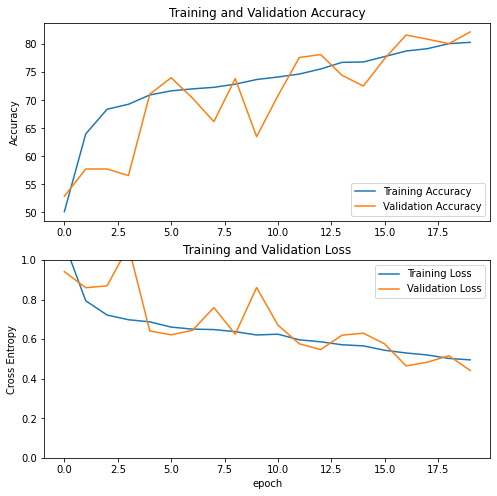

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()